In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import cv2
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from pathlib import Path
import sys
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline")
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline/segment")
from semif_utils.utils import cutoutmeta2csv
from semif_utils.utils import apply_mask

# Helper functions

In [107]:
def batch_df(df, batch_id, cutout_dir, batch_dir):
    df = pd.read_csv(Path(cutout_dir, batch_id, batch_id + ".csv"))
    df["state_id"] = df.batch_id.str.split("_", expand=False).str[0]
    df["date"] = df.batch_id.str.split("_", expand=False).str[1]
    df["cutout_paths"] = cutout_dir + "/" + batch_id + "/" + df["cutout_id"] + ".png"
    df["image_paths"] = batch_dir + "/images/" + df["image_id"] + ".jpg"
    df["meta_paths"] = batch_dir + "/metadata/" + df["image_id"] + ".json"
    df["semantic_masks"] = batch_dir + "/meta_masks/semantic_masks/" + df["image_id"] + ".png"
    df["instance_masks"] = batch_dir + "/meta_masks/instance_masks/" + df["image_id"] + ".png"
    return df

def review_data(df, batch_id):
    print("\nBatch: ", batch_id)
    print("\nTotal number of cutouts by species")
    print(df.groupby(["common_name"])["cutout_id"].nunique())
    print(len(df))

def read_metadata(path):
    with open(path, 'r') as f:
        data = json.loads(f.read())
    return data


def get_detection_data(jsonpath):
    meta = read_metadata(jsonpath)
    imgwidth, imgheight = meta['width'], meta['height']
    bboxes = meta["bboxes"]
    boxes = []
    labels = []
    for box in bboxes:
        
        # top_left = box["local_coordinates"]["top_left"]
        # bottom_right = box["local_coordinates"]["bottom_right"]
        
        # print(box["local_coordinates"].keys())
        x1 = box["local_coordinates"]["top_left"][0]
        y1 = box["local_coordinates"]["top_left"][1]
        
        x2 = box["local_coordinates"]["bottom_right"][0]
        y2 = box["local_coordinates"]["bottom_right"][1]
        
        # xywh = box["local_coordinates"]["xywh"]
        # w = xywh[2] * imgwidth
        # h = xywh[3] * imgheight
        # x1 = xywh[0] * imgwidth - w/2
        # y1 = xywh[1] * imgheight - h/2
        # x2 = x1 + w
        # y2 = y1 + h
        
        # x1, y1 = int(top_left[0]*imgwidth), int(top_left[1]*imgheight)
        # x2, y2 = int(bottom_right[0]*imgwidth), int(bottom_right[1]*imgheight)
        # print([x1, y1, x2, y2])
        boxes.append([x1, y1, x2, y2])

        label = box["cls"]["common_name"] + " (" + str(box["cls"]["class_id"]) + ")"
        labels.append(label)

    return boxes, labels


def plot_bboxes(image_file,
                bboxes,
                labels,
                xywh,
                save=False,
                save_location=".",
                figsize=(8, 12)):
    """
    Args:
      image_file: str specifying the image file path
      bboxes: list of bounding box annotations for all the detections
      xywh: bool, if True, the bounding box annotations are specified as
        [xmin, ymin, width, height]. If False the annotations are specified as
        [xmin, ymin, xmax, ymax]. If you are unsure what the mode is try both
        and check the saved image to see which setting gives the
        correct visualization.

    """
    fig = plt.figure(figsize=figsize)

    # add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])

    image_name = Path(image_file).name

    # read and plot the image
    image = plt.imread(image_file)
    plt.imshow(image)

    # Iterate over all the bounding boxes
    for i, bbox in enumerate(bboxes):
        if xywh:
            xmin, ymin, w, h = bbox
        else:
            xmin, ymin, xmax, ymax = bbox
            w = xmax - xmin
            h = ymax - ymin

        # add bounding boxes to the image
        box = patches.Rectangle((xmin, ymin),
                                w,
                                h,
                                edgecolor="red",
                                facecolor="none")

        ax.add_patch(box)

        if labels is not None:
            rx, ry = box.get_xy()
            ax.text(rx, (ry - 175),
                    str(labels[i]),
                    verticalalignment='top',
                    color='white',
                    fontsize=10,
                    weight='bold')

    # plt.axis('off')
    plt.show()
    if save:
        outfile = os.path.join(save_location, image_name)
        fig.savefig(outfile)

        print("Saved image with detections to %s" % outfile)

# def inspect_masks(df, sample_size, figsize=(8,12),random_state=42):
def inspect_masks(df_sample, figsize=(8,12),random_state=42):
    # dfs = df.sample(sample_size, random_state=random_state)
    for _, df in df_sample.iterrows():
        print("Common name: ", df.common_name)
        imgpath = df["image_paths"]
        maskpath = df["semantic_masks"]
        instancepath = df["instance_masks"]
        bgr = cv2.imread(imgpath)
        rgbimg = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        bgrsemmask = cv2.imread(maskpath)
        print("Unique semantic mask values (class_id): ",np.unique(bgrsemmask[...,0]))
        rgbmask = cv2.cvtColor(bgrsemmask, cv2.COLOR_BGR2RGB)

        bgrinmask = cv2.imread(instancepath)
        rgbinstance = cv2.cvtColor(bgrinmask, cv2.COLOR_BGR2RGB)

        _, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=figsize)
        ax1.imshow(rgbimg)
        ax2.imshow(rgbmask)
        ax3.imshow(rgbinstance)

        ax1.axis(False)
        ax2.axis(False)
        ax3.axis(False)

        ax1.title.set_text('Color image')
        ax2.title.set_text('Semantic mask')
        ax3.title.set_text('Instance mask')

        plt.tight_layout()
    # plt.savefig(save_cutout_path, bbox_inches="tight", transparent=True, dpi=300)
        plt.show()
        plt.close()

def filter_by_area(df, area_min, area_max):

    desc = df["area"].describe()
    if area_min == "mean":
        df = df[df["area"] > desc.iloc[1]]
    if area_max == "mean":
        df = df[df["area"] < desc.iloc[1]]
    if area_min == 25:
        df = df[df["area"] > desc.iloc[4]]
    if area_max == 25:
        df = df[df["area"] < desc.iloc[4]]
    if area_min == 50:
        df = df[df["area"] > desc.iloc[5]]
    if area_max == 50:
        df = df[df["area"] < desc.iloc[5]]
    if area_min == 75:
        df = df[df["area"] > desc.iloc[6]]
    if area_max == 75:
        df = df[df["area"] < desc.iloc[6]]
    return df


def filter_by_solidity(df, solid_min, solid_max):

    if solid_min != None:
        df = df[df["solidity"] > solid_min]

    if solid_max != None:
        df = df[df["solidity"] < solid_max]

    return df

def filter_by_num_components(df, component_min, component_max):
    if component_min != None:
        df = df[df["num_components"] > component_min]

    if component_max != None:
        df = df[df["num_components"] < component_max]
    
    return df

def preview_cutout_results(df, number_of_samples, extends_border, is_primary,
                           green_sum_max, green_sum_min, area_min, area_max,
                        solid_min, solid_max,component_min, component_max,
                           random_sample_state, fig_save_dir, save=False):
    mdf = df.copy()
    if extends_border != None:
        mdf = mdf[mdf["extends_border"] == extends_border]
    if is_primary != None:
        mdf = mdf[mdf["is_primary"] == is_primary]
    if green_sum_min != None:
        mdf = mdf[mdf["green_sum"] > green_sum_min]
    if green_sum_max != None:
        mdf = mdf[mdf["green_sum"] < green_sum_max]
    if area_min != None and area_max != None:
        mdf = filter_by_area(mdf, area_min, area_max)
    if solid_min != None and solid_max != None:
        mdf = filter_by_solidity(mdf, solid_min, solid_max)
    if component_min != None or component_max != None:
        mdf = filter_by_num_components(mdf, component_min, component_max)

    print("\nNumber of filtered cutouts by species:")
    print(mdf.groupby(["common_name"])["cutout_id"].nunique())
    print(len(mdf))

    for species in mdf["common_name"].unique():
        sdf = mdf[mdf["common_name"] == species]

        if len(sdf) == 0:
            print(f"{species} None")
            continue

        print(species)
        if len(sdf) < number_of_samples:
            imgpsdf = sdf.sample(len(sdf), random_state=random_sample_state)
        else:
            imgpsdf = sdf.sample(number_of_samples,
                                 random_state=random_sample_state)

        for _, row in imgpsdf.iterrows():
            cutimgp = row["cutout_paths"]
            cropimgp = row["cutout_paths"].replace(".png", ".jpg")
            cutmaskp = row["cutout_paths"].replace(".png", "_mask.png")
            save_cutout_path = Path(
                f"{fig_save_dir}/{row['common_name']}/{Path(row['cutout_id'])}.png"
            )

            Path(save_cutout_path.parent).mkdir(exist_ok=True, parents=True)

            cropimg = cv2.cvtColor(cv2.imread(cropimgp, -1), cv2.COLOR_BGR2RGB)

            cutimg = cv2.cvtColor(cv2.imread(cutimgp, -1), cv2.COLOR_BGR2RGB)

            cutmask = cv2.imread(cutmaskp, -1)

            cutimg = apply_mask(cutimg, cutmask, "black")

            _, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(cropimg)
            ax2.imshow(cutimg)

            ax1.axis(False)
            ax2.axis(False)
            
            species = row["common_name"]
            ax1.title.set_text(f'Color image ({species})')
            ax2.title.set_text(f'Original cutout ({species})')

            plt.tight_layout()
            if save:
                plt.savefig(save_cutout_path, bbox_inches="tight", transparent=True, dpi=300)
            plt.show()
            plt.close()
    return cutmask

# Define directories and load data

In [103]:
# batch_id = 'NC_2023-02-03'
# batch_id = 'NC_2023-02-06'
# batch_id = 'NC_2023-02-20'
# batch_id = 'NC_2023-02-22'
batch_id = 'NC_2023-03-07'

cutout_dir = "/home/psa_images/SemiF-AnnotationPipeline/data/semifield-cutouts"
batch_dir = f"../data/semifield-developed-images/{batch_id}"
csv_path = Path(cutout_dir, batch_id, batch_id + ".csv")

ogdf = pd.read_csv(csv_path)
# df = cutoutmeta2csv(cutout_dir, batch_id, Path(cutout_dir, batch_id, batch_id + ".csv"), save_df=False)
ogdf = batch_df(ogdf, batch_id, cutout_dir, batch_dir)

## Review species distributions

In [104]:
review_data(ogdf, batch_id)


Batch:  NC_2023-03-07

Total number of cutouts by species
common_name
Cereal rye       494
Triticale       1054
Winter wheat    1264
colorchecker      27
Name: cutout_id, dtype: int64
2839


# Create data samples

In [105]:
sample_sz = 10
random_state = 42
df = ogdf.drop_duplicates(subset='image_paths', keep="first")
df = df.sample(sample_sz, random_state=random_state)
review_data(df, batch_id)


Batch:  NC_2023-03-07

Total number of cutouts by species
common_name
Cereal rye      3
Triticale       4
Winter wheat    2
colorchecker    1
Name: cutout_id, dtype: int64
10


# Check bounding boxes

KeyboardInterrupt: 

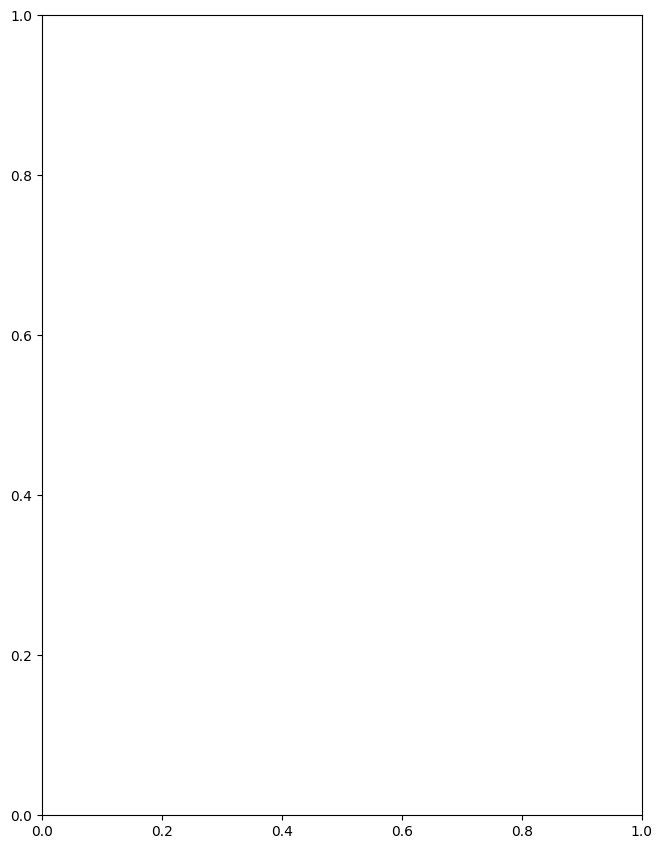

In [101]:
for idx, i in df.iterrows():
    image_path = i["image_paths"]
    bboxes, labels = get_detection_data(i["meta_paths"])
    plot_bboxes(image_path, bboxes, labels, figsize=(6, 8), xywh=False)

# Check image masks

In [ ]:
sample_size = 10
random_state = 12
fgsize = (8,12)
# inspect_masks(df, sample_size, figsize=fgsize, random_state=random_state)
inspect_masks(df, figsize=fgsize, random_state=random_state)

# Check cutouts


Number of filtered cutouts by species:
common_name
Cereal rye      3
Triticale       4
Winter wheat    2
Name: cutout_id, dtype: int64
9
Cereal rye


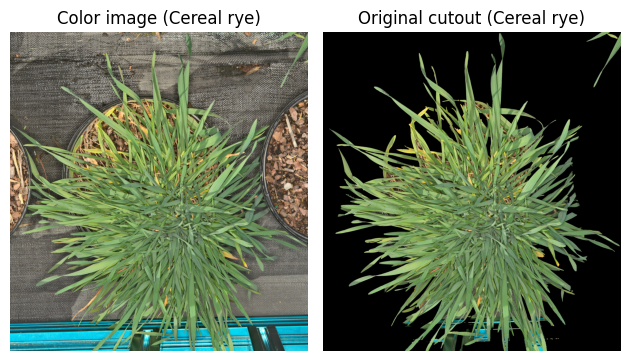

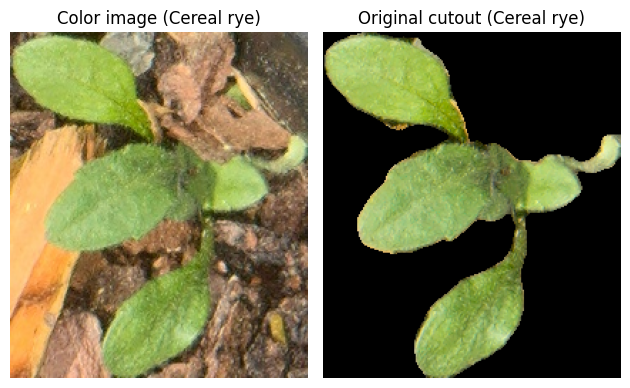

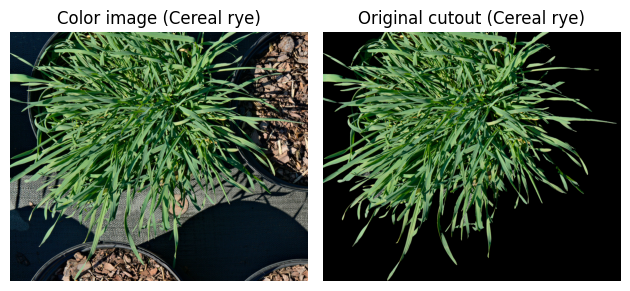

Triticale


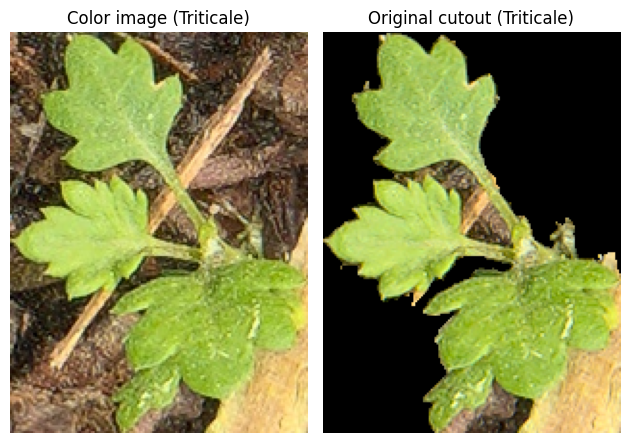

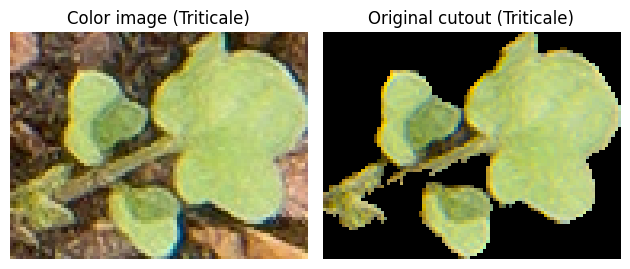

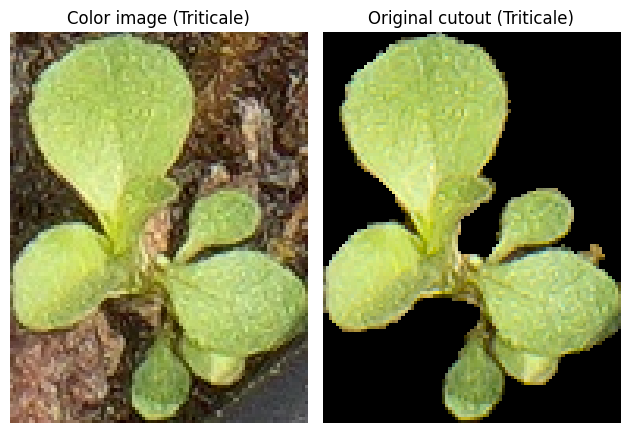

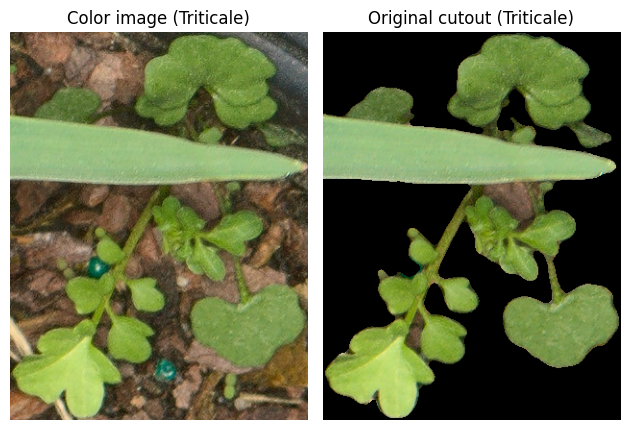

Winter wheat


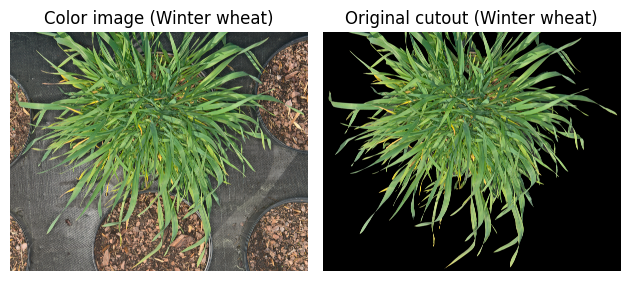

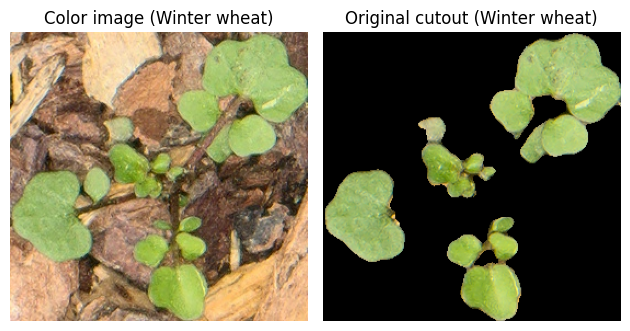

In [106]:
############################################################
# Configs (change these)
number_of_samples = 10
extends_border = None #True
is_primary = None #True
green_sum_max = 1000000000
green_sum_min = 10
# percentiles: 25, 50, 75 quartiles, mean, or None
area_min = None
area_max = None
# should be between 0 and 1
solid_max = None
solid_min = None
#number of components
component_min = None
component_max = None

random_sample_state = 42
fig_save_dir = "../assets/confluence_examples_covers"
############################################################

mask = preview_cutout_results(df, number_of_samples, extends_border,
                              is_primary, green_sum_max, green_sum_min,
                              area_min, area_max, solid_min, solid_max,
                              component_min, component_max,
                              random_sample_state, fig_save_dir, save=False)